In [1]:
%pylab qt
import scipy.integrate as integrate
from IPython import display

Populating the interactive namespace from numpy and matplotlib


In [5]:
#Euler numerical method (no curviture)

# define domain and lattice
dx = 0.1
dt = 0.001
tf = 400.0
t_max = int(tf/dt)
Lmax = 30.0 
Lmin = -10.0
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)



a0 = 1.0
nu = 0.9
h0 = 2.0

hubRad = 1.0
NHub = int((2.0*hubRad)/dx)  # number of lattice sites that spike proteins can occupy


        

# initialize As and Ac for each run through
As = zeros(Nx)
As[xs > 0.0] = a0*1.0
Ac = zeros(Nx)
AHub0 = h0 * ones(NHub)
AHub = AHub0
xp = 0.0


v_t = []
for t in range(t_max):
    
    leftBdry = xp - hubRad    # left and right boundary for spike protein distribution
    rightBdry = xp + hubRad
    xHub = linspace(leftBdry, rightBdry, NHub)
    
    diffMat = abs(xHub[:,newaxis] - xs)
    expMat = exp(-0.5*diffMat**2)  # NHub by N matrix
    
    PNum = expMat*AHub[:,newaxis]
    
    Pxx = PNum/sum(PNum, axis = 0)  # probability that a given substrate protein binds with hub protein (columns normalized)
    
    #total_f = trapz(trapz(Pxx*diffMat, x = xHub,axis = 0)*Ac, x=xs)
    centerNum = trapz(AHub0-AHub,x=xHub)
    if centerNum < 1e-8:
        AHubCenter = xp
    else:
        AHubCenter = trapz((AHub0-AHub)*xHub,x=xHub)/centerNum
    total_f = -trapz((AHubCenter-xs)*Ac,x=xs)
    binding = trapz(expMat*outer(AHub,As), x=xHub, axis = 0)     
    burnt = nu * Ac
    Ac += (binding - burnt) * dt
    As += - binding * dt
    AHub =  AHub0 - sum(Ac*Pxx, axis = 1) 
    xp += total_f * dt 
    v_t.append(total_f)
    if t % 1000 == 0:
        display.clear_output(wait=True)
        plot(xHub, AHub0-AHub, label = 'Bh')
        plot(xs,Ac, label = 'Ac')
        plot(xs,As, label = 'As')
        #axvline(x=xp, color = "red")
        #axvline(x=AHubCenter, color = "green")
        text(-10,0.1,total_f)
        legend()
        display.display(gcf())
        cla()
        
        #input("Press enter to continue")
    if xp >= 10.0:
        break

KeyboardInterrupt: 

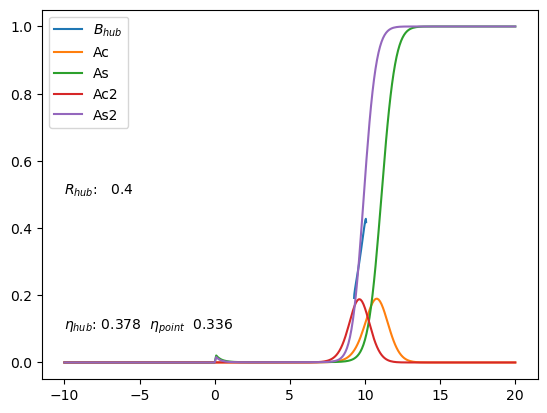

In [27]:
#Euler method with curviture 
#comparing with point-like hub

# define domain and lattice
dx = 0.1
dt = 0.001
tf = 400.0
t_max = int(tf/dt)
Lmax = 20.0 
Lmin = -10.0
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

a0 = 1.0
nu = 1.0
h0 = 10.0 # amount of available hub protein concentration at each lattice site

def xHubCurv(xp):
    return xp + hubRad * sin(phis)




hubRads = logspace(-1,2,2,base=2)*dx

for hubRad in hubRads:
    phiCrit = pi * 0.5 # substrate can bind anything in [-phiCrit, phiCrit]
    NHub = int((2.0*phiCrit*hubRad)/dx)  # number of lattice sites that spike proteins can occupy
    if NHub == 1:
        phis = zeros(1)
    else:
        phis = linspace(-phiCrit,phiCrit,NHub)
    # initialize As and Ac for each run through
    As = zeros(Nx)
    As[xs > 0.0] = a0*1.0
    Ac = zeros(Nx)
    AHub0 = h0 * ones(NHub)
    AHub = AHub0
    xp = 0.0

    #setup point like hub
    As2 = zeros(Nx)
    As2[xs > 0.0] = a0*1.0
    Ac2 = zeros(Nx)
    xp2 = 0.0
    for t in range(t_max):
        xHub = xHubCurv(xp)
        diffMat = abs(xHub[:,newaxis] - xs)
        stretchMat = sqrt((xp + hubRad*sin(phis[:,newaxis]) - xs)**2 + hubRad**2*(1-cos(phis[:,newaxis]))**2 )
        expMat = exp(-0.5*stretchMat**2)  # NHub by N matrix

        PNum = expMat*AHub[:,newaxis]

        Pxx = PNum/sum(PNum, axis = 0)  # probability that a given substrate protein binds with hub protein (columns normalized)

        # find the center of mass for the hub protein distribution
        centerDenom = trapz(AHub0-AHub,x=xHub)
        if centerDenom < 1e-8:# was an issue when centerDenom was zero
            AHubCenter = xp
        else:
            AHubCenter = trapz((AHub0-AHub)*xHub,x=xHub)/centerDenom

        total_f = -trapz((AHubCenter-xs)*Ac,x=xs)
        binding = sum(expMat*Pxx,axis=0)* As     
        burnt = nu * Ac
        Ac += (binding - burnt) * dt
        As += - binding * dt
        AHub =  AHub0 - sum(Ac*Pxx, axis = 1) 
        xp += total_f * dt
        burnRate = trapz(burnt,x=xs)
        #eff = total_f**2/burnRate


        total_f2 = -trapz((xp2-xs)*Ac2,x=xs)
        binding2 = exp(-0.5*(xp2-xs)**2)*As2    
        burnt2 = nu * Ac2
        Ac2 += (binding2 - burnt2) * dt
        As2 += - binding2 * dt 
        xp2 += total_f2 * dt 
        burnRate2 = trapz(burnt2,x=xs)
        eff2 = total_f2**2/burnRate2

        if t % 1000 == 0:
            display.clear_output(wait=True)
            plot(xHub, AHub0-AHub, label = '$B_{hub}$')
            plot(xs,Ac, label = 'Ac')
            plot(xs,As, label = 'As')
            plot(xs,Ac2, label = 'Ac2')
            plot(xs,As2, label = 'As2')
            #axvline(x=xp, color = "red")
            #axvline(x=AHubCenter, color = "green")
            text(-10,0.1,r"$\eta_{hub}$: "+str(round(burnRate,3))+ r"  $\eta_{point}$  "+str(round(eff2,3)))
            text(-10,0.5,"$R_{hub}$:   "+str(round(hubRad,3)))
            legend()
            display.display(gcf())
            cla()

        if xp >= 10.0:
            plot(xHub, AHub0-AHub, label = '$B_{hub}$')
            plot(xs,Ac, label = 'Ac')
            plot(xs,As, label = 'As')
            legend()
            break



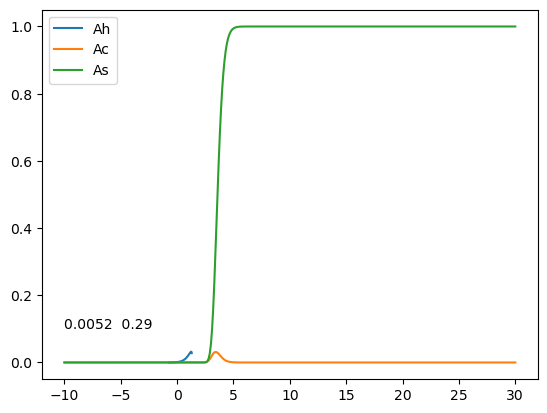

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-f7e4f7d8cb4f>", line 61, in <module>
    angleint = trapz(Pxx*(1-cos(phis[:,newaxis])),axis=0,x=phis)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\ProgramData\Anaconda3\li

TypeError: object of type 'NoneType' has no len()

In [2]:
#Euler method with curviture, torque and rolling

# define domain and lattice
dx = 0.1
dt = 0.001
tf = 400.0
t_max = int(tf/dt)
Lmax = 30.0 
Lmin = -10.0
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)



a0 = 1.0
nu = 0.9
h0 = 2.0

hubRad = 1.0
phiCrit = pi * 0.5 # substrate can bind anything in [-phiCrit, phiCrit]
NHub = int((2.0*phiCrit*hubRad)/dx)  # number of lattice sites that spike proteins can occupy
phis = linspace(-phiCrit,phiCrit,NHub)

def xHubCurv(xp):
    return xp + hubRad * sin(phis)
        

# initialize As and Ac for each run through
As = zeros(Nx)
As[xs > 0.0] = a0*1.0
Ac = zeros(Nx)
AHub0 = h0 * ones(NHub)
AHub = AHub0
xp = 0.0


v_t = []
for t in range(t_max):
    
    leftBdry = xp - hubRad    # left and right boundary for spike protein distribution
    rightBdry = xp + hubRad
    xHub = xHubCurv(xp)
    
    diffMat = abs(xHub[:,newaxis] - xs)
    stretchMat = sqrt((xp + hubRad*sin(phis[:,newaxis]) - xs)**2 + hubRad**2*(1-cos(phis[:,newaxis]))**2 )
    expMat = exp(-0.5*stretchMat**2)  # NHub by N matrix
    
    
    
    PNum = expMat*AHub[:,newaxis]
    
    Pxx = PNum/sum(PNum, axis = 0)  # probability that a given substrate protein binds with hub protein (columns normalized)
    
    # find the center of mass for the hub protein distribution
    centerNum = trapz(AHub0-AHub,x=xHub)
    if centerNum < 1e-8:# was an issue when centerNum was zero
        AHubCenter = xp
    else:
        AHubCenter = trapz((AHub0-AHub)*xHub,x=xHub)/centerNum
    
    angleint = trapz(Pxx*(1-cos(phis[:,newaxis])),axis=0,x=phis)
    total_f = trapz(angleint*(xs-xp)*Ac,x=xs)
    
    binding = trapz(expMat*outer(AHub,As), x=xHub, axis = 0)     
    burnt = nu * Ac
    Ac += (binding - burnt) * dt
    As += - binding * dt
    AHub =  AHub0 - sum(Ac*Pxx, axis = 1) 
    xp += total_f * dt 
    v_t.append(total_f)
    if t % 1000 == 0:
        
        
        
        
        
        
        
        
        
        
        
        #input("Press enter to continue")
    if xp >= 10.0:
        plot(xHub, AHub0-AHub, label = 'Ah')
        plot(xs,Ac, label = 'Ac')
        plot(xs,As, label = 'As')
        legend()
        break

In [33]:
plot(phis, AHub0-AHub, label = 'Bh')
xlabel(r"$\phi$")

Text(0.5, 0, '$\\phi$')